# ***Background Introduction***

Many factors could determine the success of movies. What are they and how they influence the success of a single movie? This is the question we would like to ask. We define success as both financially and evaluatively. The success of high box office is the same for us as the high votes by the public. 

Not all movies with big productions will have great financial success as well as the success among critics. Especially, in the recent years, movies with low production costs but high qualities are getting noticed by the mainstream. Therefore, we predict that some obvious factors may not be the strongest in determining movie revenue, and there should be unnoticeable factors we could find by analyzing different datasets. Those factors include: Actors, genre, year released, production company, rating, as well as the keywords most related to the movie. We predict that these factors will influence each other in a way that allows us to determine if a movie will be a box office seller or the favorite by critics.

## Project Outline##
This notebook is divided into several parts that mainly focused on a specific factor and its influence on the movie revenue or profit. We want to explore different factors as deep as possible and these factors include explicit ones like budgets, genres, but also implicit ones like the relationship between production companies and the combinations of different genres. We use different data cleaning and analyse strategy in different sections due to the different focus on each part and at the end of our project, we hope to find a strong factor or a combination of many factors that affects a movie’s revenue and thus understand what the movie industry can improve by using less but important resource and thus making more successful movies and more money.

## Source of Data and Privacy Concerns##

The database we use to explore and find those factors is the public dataset "TMDB 5000 movies" from Kaggle (link:https://www.kaggle.com/tmdb/tmdb-movie-metadata/data). It contains 5000 movies which are authorized to be publicly analyzed so the data collection process does not involve any privacy issues. The dataset contains 2 CSV files, 'tmdb_5000_movies.csv' and 'tmdb_5000_credits.csv'. They contain all information like the name of actors and casts, the keywords most related to the movies, production companies.etc. 

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import json
import patsy
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import itertools
from scipy.stats import ttest_ind, chisquare, normaltest
from scipy.stats import gaussian_kde
%matplotlib inline


# ***Production Companies and Profit***

**The main focus of this part of our project is to figure out how companies can influence a movie's net profit and revenue. We believe movies of a certain genre will have higher net-profit if they are produced by the companies that are excelled in making that certain genre of movies. Furthermore if our first asumption holds, we are also interested to find out what genre of movies that the most profitable produciton companies like to make and what are the average votes for those movies made by the most profitable companies. Along the way, we will also examine the relationship between budget and revenue, and the correlation what whether production companies that have made many movies of certain genre will have higher chance producing movies with higher profit and votes.**






In [114]:
df = pd.read_csv('tmdb_5000_movies.csv')


***Data cleaning:***
For this part, we don't need the columns contain the trivial information like id, language, runtime, movies' home page. So we drop these columns we don't need. 

In [115]:
df = df.drop(['homepage','original_language','overview','runtime','status','tagline', 'id' ], axis = 1 )

**Now we create a new column called net_pofit which denotes the profit earns by each movies. Then we clean up the data by dropping the rows with missing budget and revenue. Because columns like genres, keywords and production_companies are like list objects with dictionary inside, it is hard to do our study with these complicated data structures. Thus we need to "flaten" these lists into string are that esier to work with.**

In [116]:
df['net_profit'] = df['revenue'] - df['budget']

## drop rows when budget or revenue is 0 
df = df[df.budget != 0]
df = df[df.revenue != 0]
df = df[df.revenue - df.budget > 0]
df = df.reset_index(drop=True)

**Here we will create methods to clean the data and apply them to the columns to allow for easier access and analysis. **

In [117]:

# methods for cleaning the data into an easier to access form 
def flaten_name(keywords): 
  return '|'.join([x['name'] for x in keywords])

def safe_approach(input, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = input
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
      
      
#apply the methods to columns

df['genres'] = df['genres'].apply(json.loads)
df['genres'] = df['genres'].apply(flaten_name)

df['keywords'] = df['keywords'].apply(json.loads)
df['keywords'] = df['keywords'].apply(flaten_name)

df['production_companies'] = df['production_companies'].apply(json.loads)
df['production_companies'] = df['production_companies'].apply(flaten_name)

df['production_countries'] = df['production_countries'].apply(json.loads)
df['production_countries'] = df['production_countries'].apply(flaten_name)


df['spoken_languages'] = df['spoken_languages'].apply(json.loads)
df['spoken_languages'] = df['spoken_languages'].apply(flaten_name)

df.head()

,budget,genres,keywords,original_title,popularity,production_companies,production_countries,release_date,revenue,spoken_languages,title,vote_average,vote_count,net_profit
0,237000000,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,Avatar,150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009-12-10,2787965087,English|Español,Avatar,7.2,11800,2550965087
1,300000000,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Pirates of the Caribbean: At World's End,139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America,2007-05-19,961000000,English,Pirates of the Caribbean: At World's End,6.9,4500,661000000
2,245000000,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Spectre,107.376788,Columbia Pictures|Danjaq|B24,United Kingdom|United States of America,2015-10-26,880674609,Français|English|Español|Italiano|Deutsch,Spectre,6.3,4466,635674609
3,250000000,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,The Dark Knight Rises,112.312950,Legendary Pictures|Warner Bros.|DC Entertainme...,United States of America,2012-07-16,1084939099,English,The Dark Knight Rises,7.6,9106,834939099
4,260000000,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,John Carter,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,English,John Carter,6.1,2124,24139100


***Genres and companies***

**Our goal here is to analyze whether production_companies that made many movies of a certain genre will be more likely to produce a movie of that genre with higher profit. To do so, we create a dataframe that contains how many and what type of movies each movie production companies have made.**



In [118]:
# get a list of genres

#First let's get a set of genres present
list_genre = set() 
for s in df['genres']: 
    s = s.split('|')
    list_genre = set().union(s, list_genre)
list_genre = list(list_genre)
#list_genre.remove('')
list_genre

['Music',
 'Drama',
 'Family',
 'Animation',
 'Mystery',
 'Fantasy',
 'Documentary',
 'Action',
 'Thriller',
 'History',
 'War',
 'Adventure',
 'Romance',
 'Horror',
 'Science Fiction',
 'Comedy',
 'Crime',
 'Western']

**Here we will create a list of each production company.**

In [119]:
# get a list of produciton company 
list_company = set() 
for s in df['production_companies']:
  s = s.split('|')
  list_company = set().union(s,list_company)
list_company = list(list_company)
list_company.remove('')
len(list_company)
print('There are',len(list_company),'different production companies in our data set')

There are 2723 different production companies in our data set


**Below we create a list for each movie genre to count how many movies in each of genres**

In [120]:
# create a list for each movie genre
Action = [] 
Animation = [] 
Horror = [] 
Mystery = [] 
Thriller = [] 
Drama = [] 
Crime = [] 
Fantasy = [] 
Documentary = [] 
Science_Fiction = [] 
Romance = [] 
Family = [] 
History = [] 
Comedy =[] 
Western = [] 
Music = [] 
Adventure = [] 
War = [] 
TV_Movie = [] 
Foreign = [] 

# create a mother list 'genre' that contains all genre lists

genre = [Mystery,Family,War,Romance,Drama,Documentary,History,Fantasy,Adventure,
Thriller,Horror,Crime,Science_Fiction,Music,Action,Comedy,Western,Animation]
len(genre) == len(list_genre)

count = 0 
for movie in range(len(df)) : 
  g = df.loc[movie][1].split('|')
  c = df.loc[movie][5].split('|')
  
  for i in list_genre:  
    if i in g: 
      genre[count] = genre[count]+c
    count = count+1
  count = 0 

**Now that we have the genre, we want to create a data frame that relates each company and the genre of movies they create.**

In [121]:
from collections import Counter
#Counter(genre[1])
df_cg =  pd.DataFrame(columns =['Company']+list_genre)
#add company names to the 'Company' column in df_cg
df_cg['Company'] = list_company

# fill in the dataframe with number of movies for every genre that each company 
# has made in the 5000 movie dataset
for j in range(len(list_genre)):   
  for i in range(len(df_cg)): 
    df_cg.loc[i][1+j] = Counter(genre[j])[df_cg.loc[i][0]]
df_cg = df_cg.set_index('Company')

df_cg.head()

,Music,Drama,Family,Animation,Mystery,Fantasy,Documentary,Action,Thriller,History,War,Adventure,Romance,Horror,Science Fiction,Comedy,Crime,Western
Company,,,,,,,,,,,,,,,,,,
Lucasfilm,0,1,1,1,0,1,0,10,0,0,0,11,0,0,7,2,0,0
Dovemead Films,0,0,0,0,0,3,0,3,0,0,0,3,0,0,3,1,0,0
SNL Studios,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Core Productions,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0
Resident Evil Productions,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0


**Next we are going to relate production companies with a specific genre. Let's start with the action genre. **

In [122]:
# Select all the action movies from the original dataframe and create a 
# new data frame called df_action

# create list of indexs of all action movies
list_action = [] 
counter = 0 
for s in df['genres']:
  s = s.split('|')
  if 'Action' in s: 
    list_action.append(counter)
  counter = counter + 1


In [123]:
df_action = df.iloc[list_action]
df_action = df_action.reset_index(drop=True)



In [124]:
# we figure out the how many action movies we have from these 5000 movies
action_num = len(df_action )
# percentage of action movies in the original dataset 
action_num/len(df)

0.28424938474159145

In [125]:
# next we shall figure out the aveg net_gain of each company that makes action movie  

# First of all we find the total action movie netprofit for each company in df_action 
# We start off by building a set of companies that make action movies
list_company_action = set() 
for s in df_action['production_companies']:
  s = s.split('|')
  list_company_action = set().union(s,list_company_action)
list_company_action = list(list_company_action)
list_company_action.remove('')
len(list_company_action)
print('There are',len(list_company_action),'different production companies in action movie data set')



There are 983 different production companies in action movie data set


In [126]:
# now we turn lis_company_action into a dictionary and start calculating the 
# total net_profit for each company
dict_company_action = {x:0 for x in list_company_action}

In [127]:

# df_action.loc[0][13] is profit 
# df_action.loc[0][5] is company


for i in range(len(df_action)): 
  s = df_action.loc[i][5].split('|')
  for j in range(len(list_company_action)):
    if list_company_action[j] in s: 
      dict_company_action[list_company_action[j]] =  dict_company_action[list_company_action[j]]+ df_action.loc[i][13]
  

In [128]:
  # dict_company_action is a dictionary list that contains the netprofit for company making action movies
  # Next, we want to figure out the average profit for each company making action movies
  
  df_cg.loc['Capcom']
  for i in list_company_action: 
          dict_company_action[i] = dict_company_action[i]/df_cg.loc[i][14]
  

C:\Users\slayerjensen\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in longlong_scalars
  


**Here we create a dataframe to hold all the information related to the companies making action movies. We then plot graphs demonstrating the change of numbers of movies made in each genre and its profit.**

In [129]:
# next we want to plot the relationship between the number of action movies each 
# company had made and the average netprofit of each company

df_action_company =  pd.DataFrame(columns =['Company','net_profit','number'])
df_action_company['Company'] = list_company_action
list_profit_action = []
list_number_action = [] 
for i in list_company_action: 
  list_profit_action.append(dict_company_action[i])
  list_number_action.append(df_cg.loc[i][14])
df_action_company['net_profit'] = list_profit_action
df_action_company['number'] = list_number_action 
#df_action_company
 

In [130]:
## this is the method for creating a list of all the desired type of movie
def create_df_type(lis,ty):
    
    counter = 0
    for s in df['genres']: 
        if ty in s:
            lis.append(counter)
            counter = counter + 1
  
#this method creates a list of companies making the desired movie type 
def create_company_type(df_type): 
    
    type_company  = set()
    for s in df_type['production_companies']:
        
        s = s.split('|')
        type_company = set().union(s,type_company)
        type_company = list(type_company)
        if '' in type_company:
            type_company.remove('')
    return type_company
    
# this method will fill in the dictionary 
def dict_mean(dictionary, lis, df_type): 
    
    for i in range(len(df_type)): 
        
        s = df_type.loc[i][5].split('|')
        for j in range(len(lis)):
            if lis[j] in s: 
                dictionary[lis[j]] = dictionary[lis[j]] + df_type.loc[i][13]
    
# this method will plot the relationship between the number of the desired
# type of movie and the average netprofit for each company

def plot_numprofit(df_type,lis,dictionary,num,name):
    
    df_type['Company'] = lis
    list_profit_type = [] 
    list_number_type = [] 
    for i in lis:
        
        list_profit_type.append(dictionary[i])
        list_number_type.append(df_cg.loc[i][num])
    df_type['net_profit'] = list_profit_type
    df_type['number'] = list_number_type
    sns.lmplot(x='number',y='net_profit',data=df_type,fit_reg=False)
    title='The relationship between number of '+name+' movies made and the average profit'
    ax=plt.gca()
    ax.set_title(title)
 


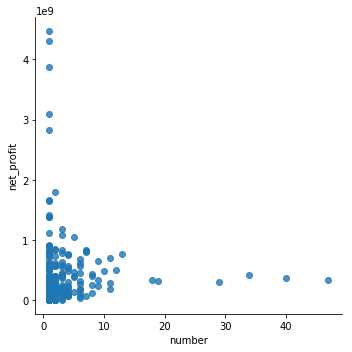

In [131]:
#df_action_company
#plot_numprofit(df_action_company,list_company_action,dict_company_action,num = 6,'action')
sns.lmplot(x='number',y='net_profit',data=df_action_company,fit_reg=False)

**The graph above shows the relationship between experience of production companies making a action movies and how much profit boost those action movie will recieve from those experience. Within the graph, each dot represent a company that have made an action movie. The axis means how many action movies each companies have made and the y-axis represent the average profit of action movies each companies have received. From the graph, we can see no signifiant correlation between experience and average movie profit as values of y-axis do not significantly increases as the x increases.**

C:\Users\slayerjensen\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in longlong_scalars
  # This is added back by InteractiveShellApp.init_path()


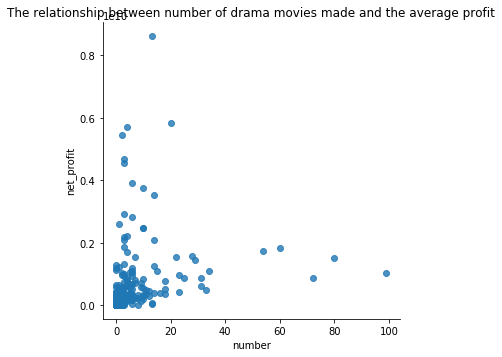

In [132]:
list_drama = [] 
create_df_type(list_drama,'Drama')
df_drama = df.iloc[list_drama]
df_drama = df_drama.reset_index(drop=True)
list_company_drama = create_company_type(df_drama)
dict_company_drama = {x:0 for x in list_company_drama}
dict_mean(dict_company_drama,list_company_drama ,df_drama)
for i in list_company_drama: 
    
    try:
        dict_company_drama[i] = dict_company_drama[i]/df_cg.loc[i][4]
    except: 
        pass
df_drama_company = pd.DataFrame(columns =['Company','net_profit','number'])
plot_numprofit(df_drama_company,list_company_drama,dict_company_drama,num = 1,name='drama')



**This graph also shows that there is no significant correlation between company experience and profit boost for drama movies. As we can see that the profit does not increase as the number value increases. Actually, it is quite the inverse; Most drama movies with high profit aren't made by the most experienced drama genre production companies.**

## Analysis on relationship between revenues and budget and votes##

**Now, doing a linear regression we test to see if there is a significant relationship between revenue and budget(OLS analysis) of movies .We would take log10 of budget and revenue to gain  a better result** 

In [133]:
#Create linear regression
df_br=df.copy(deep=True)
df_br.dropna(subset=['revenue','budget'],inplace=True)
df_br['revenue']=df.revenue.mask(df_br.revenue==0,1)
df_br['budget']=df_br.budget.mask(df_br.budget==0,1)
df_br['revenue']=np.log10(df_br['revenue'])
df_br['budget']=np.log10(df_br['budget'])
outcome, predictors = patsy.dmatrices('revenue~ budget', df_br)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     4236.
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:38:37   Log-Likelihood:                -1088.1
No. Observations:                2438   AIC:                             2180.
Df Residuals:                    2436   BIC:                             2192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8296      0.078     36.299      0.0

**By the R-squared and p- value shown above, we can conclude that the relationship between revenue and budget is strong, let's see how the relationship is present in a plot.**

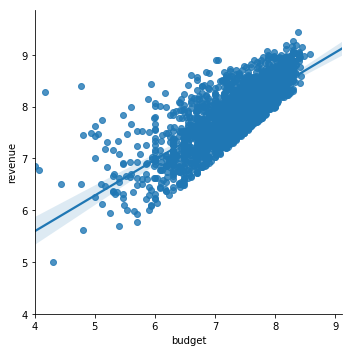

In [134]:
#plot the linear regression graph showing the budget revenue relation
fig=sns.lmplot(x='budget',y='revenue',data=df_br,fit_reg=True) 
fig.set(xlim=(4, None))
fig.set(ylim=(4,None))
#fig.xticks([0,1,2,3,4,5,6,7,8,9,10])

**The graph above clearly demonstrates the strong coorelation between budget and revenue( we exclude outliers in budgets which are relatively small). Now we want to know which genre would makes the higest revenue in general. The median is a good representation of general situation here.**

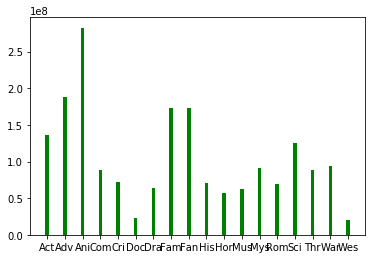

In [135]:
#take median of the genere movies as it indicates the situations better 
def get_genre_avg_revenue(genre):
  list_index=[]
  counter=0
  for string in df['genres']:
    if genre in string:
      list_index.append(counter)
    counter+=1
  #take medians for the revenue
  return (df.iloc[list_index]['revenue'].median())

def convert_million(value):
    
    return '$%1.1fM' % (value * 1e-6)
      
    

#do a analysis on the average revenue by genre(how does genre affects the average revenue)
genre_dict_revenue={}
for genre in list_genre:
  genre_dict_revenue[genre]=get_genre_avg_revenue(genre)

#create a list of starting 3 chars of genre
list_dict_3_bet=[]
for genre in list_genre:
    list_dict_3_bet.append(genre[:3])
  

#plot the distribution of graph
plt.bar(list_dict_3_bet,genre_dict_revenue.values(),width=0.2, color='g')
plt.show()


#it seems that the adventure drama and music movies have the highest median revenue of the all
#then we want to see which combinations of genre could have highest median, then



**(Note that in the graph, the value in x-axis is the first 3 letters of each genre. ex: 'Act' is 'Action')The graph above shows the average profit for each genre of movies. As we can see, the most profitable genres are 'Animation', which makes sense because from the previous graph we know that movies with high budget often have high revenue. Since making an animation movies requires teremendous amount of budget, thus its high rate of return is expected.**

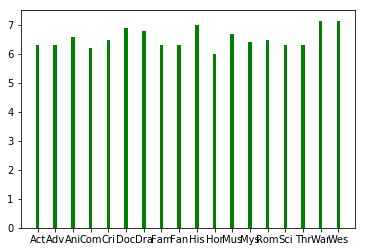

In [136]:
#do a analysis of genere vs votes
def get_genre_vote(genre):
  list_index=[]
  counter=0
  for string in df['genres']:
    if genre in string:
      list_index.append(counter)
    counter+=1
  #take medians for all movies in the genre
  return df.iloc[list_index]['vote_average'].median()

genre_dict_votes={}
for genre in list_genre:
  genre_dict_votes[genre]=get_genre_vote(genre)

#do a bar char
plt.bar(list_dict_3_bet,genre_dict_votes.values(),width=0.2, color='g')
plt.show()


**The graph above shows the genre in relation to its average score. The x-axis shows the genre of the movie and the y-axis defines the average score for that genre of movie in relation to our dataframe. We can see from here though animations makes a lot of money but they don't have the highest vote. In general war and Western have highest votes.**

# ***Analysis based on keywords of movies***

**In the dataset, there are several keywords related to the movies: Some of the movies are about "women director" and some are about "crime family". How are those keywords related to movie revenue?**

In [137]:
#What about keywords in the movies, are they have general high relationship with revenue?
#Let's get the list of keywords first and find the most popular one
#get the list of key words
liste_keywords = set()
for s in df['keywords'].str.split('|'):
    liste_keywords = set().union(s, liste_keywords)
liste_keywords = list(liste_keywords)
liste_keywords.remove('')



In [138]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
              
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count
 
keyword_occurences, dum = count_word(df, 'keywords', liste_keywords)
len(keyword_occurences)

7660

In [139]:
#create a new dataframe about the occurence of the different keyWords

In [140]:
#get a new dataframe based on keywords
#df_keywords=df.copy(deep=True)
keyword_list = set()
for s in df['keywords'].str.split('|'):
    keyword_list = set().union(s, keyword_list)
keyword_list = list(keyword_list)
keyword_list.remove('')

df_keywords = df[['title','vote_average','release_date','budget','revenue']].reset_index(drop=True)

for keyword in keyword_list:
    df_keywords[keyword] = df['keywords'].str.contains(keyword).apply(lambda x:1 if x else 0)

df_keywords.shape

C:\Users\slayerjensen\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


(2438, 7665)

**Now we would like to create a new dataframe based on keywords. We want to include the mean budget, mean revenue and mean vote related for each keyword. From the dataframe we can calculate the profit gain related to each keyword as well as the rating.** 

In [141]:
mean_for_keyword = pd.DataFrame(keyword_list)
array1=[]*len(keyword_list)
#mean vote
for keyword in keyword_list:
    array1.append(df_keywords.groupby(keyword, as_index=True)['vote_average'].mean())
 
#mean budget
array2 = []*len(keyword_list)
for keyword in keyword_list:
    array2.append(df_keywords.groupby(keyword, as_index=True)['budget'].mean())

array3 = []*len(keyword_list)
for keyword in keyword_list:
    array3.append(df_keywords.groupby(keyword, as_index=True)['revenue'].mean())

mean_for_keyword['mean_vote_average']=list(pd.DataFrame(array1)[1])
mean_for_keyword['mean_budget']=list(pd.DataFrame(array2)[1])
mean_for_keyword['mean_revenue']=list(pd.DataFrame(array3)[1]) 
mean_for_keyword.columns = ['keyword','mean_vote_average','mean_budget','mean_revenue']

In [142]:
mean_for_keyword.sort_values('mean_vote_average', ascending=False).head()


,keyword,mean_vote_average,mean_budget,mean_revenue
3276,wrongful imprisonment,8.5,25000000.0,28341469.0
1266,italian american,8.4,6000000.0,245066411.0
6208,crime family,8.4,6000000.0,245066411.0
1778,mob boss,8.4,6000000.0,245066411.0
2845,pulp fiction,8.3,8000000.0,213928762.0


In [143]:
mean_for_keyword.sort_values('mean_budget', ascending=False).head()

,keyword,mean_vote_average,mean_budget,mean_revenue
787,lex luthor,5.4,270000000.0,391081192.0
2392,blonde woman,7.4,260000000.0,591794936.0
1203,healing power,7.4,260000000.0,591794936.0
1447,mars civilization,6.1,260000000.0,284139100.0
7121,healing gift,7.4,260000000.0,591794936.0


In [144]:
mean_revenue = mean_for_keyword.sort_values('mean_revenue', ascending=False)

** Here we plot the top 50 keywords's mean revenues of each movie and denote the mean revenue gained by the top 50 keywords.**

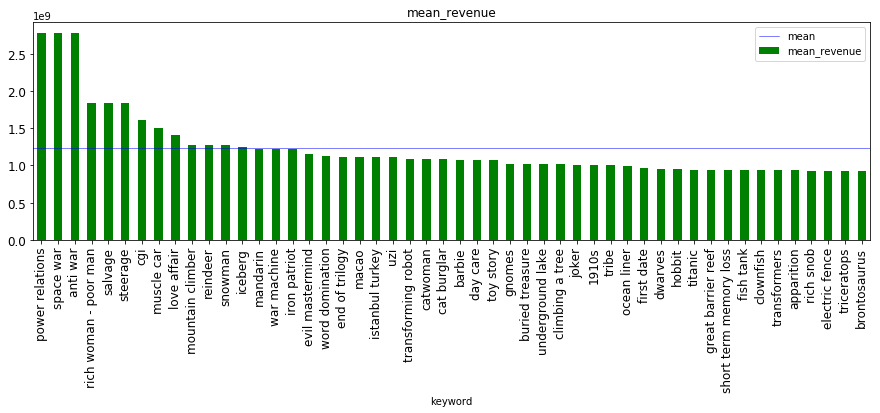

In [145]:
import matplotlib.pyplot as plt

ax = mean_revenue[0:50].plot.bar(x = 'keyword', y='mean_revenue', title="mean_revenue",
                     figsize=(15,4), legend=True, fontsize=12, color='green', label = "mean_revenue")
#ax.set_ylim(5, 8)
ax.axhline(y=mean_revenue[0:50]['mean_revenue'].mean(),c="blue",linewidth=0.5, label='mean')
ax.legend()
plt.show()




**The graph above shows that some keywords could contribute to much higher revenue for the movies.** 


## Vote vs. Revenue##

**How could votes affect the revenue of the movies? Is it true that high revenue movies would have higher ratings or vice versa? Below we show a plot and regression to visualize the relationship between votes and revenue.**

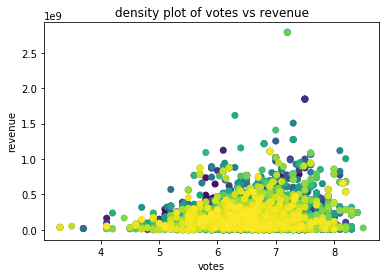

In [146]:

# relationship between mean vote and mean revenue 
x=mean_revenue['mean_vote_average'].dropna()
y=mean_revenue['mean_revenue'].dropna()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.title("density plot of votes vs revenue")
plt.xlabel("votes")
plt.ylabel("revenue")
plt.show()


**The graph above does show that most movies are with vote score around 4.5-8.5 and having a revenue bellow 1 billion. In the range of vote score 6.8-7.0  is the place where movies make the higher revenue in general by seeing the shape of yellow.**

# ***Analysis on Top 500 companies that earn the most***

**Next, lets figure out the mean net profit, mean vote average and most common genre of the top 500 companies that earn the highest revenue of all the companies. Then we can get a good overview of movies made by these high earning companies using their votes and genre. We also want to know if the coorperation of these companies could bring higher profits. We create a dataframe incluing those information we want first **

In [147]:
#Create lists
company_genre_list = [0]*len(list_company)
count_list = [0]*len(list_company)
vote_list = [0]*len(list_company)
profit_list = [0]*len(list_company)
#Loop through spliting at certain values
for i in range(len(df)): 
  genre = df.loc[i]['genres'].split('|')
  company = df.loc[i]['production_companies'].split('|')
  vote = df.loc[i]['vote_average']
  profit = df.loc[i]['net_profit']
  counter = 0
  for j in list_company: 
    if j in company: 
      vote_list[counter] += vote
      profit_list[counter] += profit 
      if company_genre_list[counter] == 0: 
        company_genre_list[counter] = [] 
      company_genre_list[counter] = company_genre_list[counter]+genre
      count_list[counter] += 1
    counter += 1


In [148]:
for i in range(len(count_list)):
  vote_list[i] = vote_list[i]/count_list[i]
  profit_list[i] = profit_list[i]/count_list[i]
  company_genre_list[i] = max(set(company_genre_list[i]), key = company_genre_list[i].count)

In [149]:
df_complex_company = pd.DataFrame(columns =['Company','mean_net_profit','mean_vote','most_common_genre'])

In [150]:
df_complex_company['mean_net_profit'] = profit_list
df_complex_company['Company'] = list_company 
df_complex_company['mean_vote'] = vote_list
df_complex_company['most_common_genre'] = company_genre_list

In [151]:
#Create dataframe that holds values
df_complex_company = df_complex_company.sort_values('mean_net_profit', ascending=False)
df_complex_company.reset_index(drop=True, inplace = True)
df_complex_company.head()

,Company,mean_net_profit,mean_vote,most_common_genre
0,"Colorado Office of Film, Television & Media",1.316249e+09,7.30,Action
1,Québec Production Services Tax Credit,1.316249e+09,7.30,Action
2,Abu Dhabi Film Commission,1.316249e+09,7.30,Action
3,Prime Focus,1.125404e+09,7.30,Science Fiction
4,Lightstorm Entertainment,9.799764e+08,7.26,Action


In [152]:
# Let's see what genres of movies that top 500 most profitable production companies 
# produce
common_genre_list = list(df_complex_company[:500]['most_common_genre'])
unique_genre_list = set(common_genre_list)
unique_genre_list = list(unique_genre_list)
count = []
for i in unique_genre_list: 
  size1 = common_genre_list.count(i)
  count.append(size1)

In [153]:
size = [round(x/500*100,2) for x in count]

**Percentage of genres companies do among top 500 companies. Do they prefer one genere over another? We draw a pie chart to show this.**

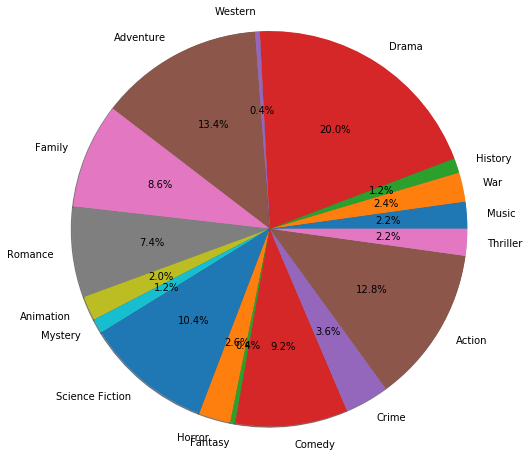

In [154]:
from matplotlib.gridspec import GridSpec
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(size, labels=unique_genre_list, autopct='%1.1f%%', shadow=True,
radius = 5)
plt.show()

**The graph above shows that these companies prefer adventure way a lot than others with 25.8% of the companies will do this genre. Then we want to see the variance of profit of those ranked companies. Which make the most or make the least.**

In [155]:
def convert_billion(value):
  return '$%1.1fB' % (value * 1e-9)

**Testing variance of revenue amoung companies and graphing results below**

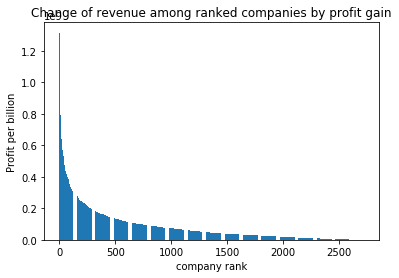

In [156]:
# Next lets see the variance of revenue among these companies
x1 = list(df_complex_company.index.get_values())
y1 = list(df_complex_company['mean_net_profit'])
plt.bar(x1, y1)
plt.title('Change of revenue among ranked companies by profit gain')
plt.xlabel('company rank')
plt.ylabel('Profit per billion')
plt.show()

**Graphing the relation between mean_votes and profits for the top 500 companies. The reason why we pick the first 500 companies is that their average income is at least 0.2 billion, which is a good indicator of being successful*

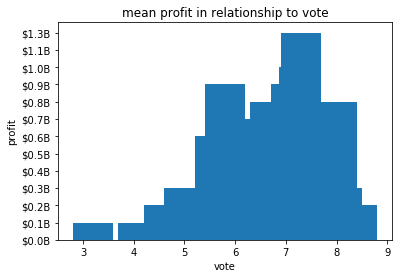

In [157]:
#Now what about the relations between the mean_votes and the profits along the 
#500 companies?
x2 = list(df_complex_company['mean_vote'])
y2 = list(df_complex_company['mean_net_profit'].apply(convert_billion))
plt.bar(x2, y2)
plt.title('mean profit in relationship to vote')
plt.xlabel('vote')
plt.ylabel('profit')
plt.show()

**The graph above shows the data is more skewed to the right. This shows the companies that produce high quailtiy movies will generally have higher profits. Then what are relationships between genre and revenue?**

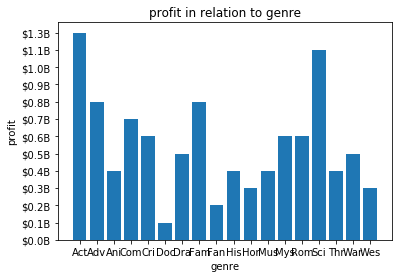

In [158]:
def convert_dit(string):
  return string[:3]


x3=list(df_complex_company['most_common_genre'].apply(convert_dit))
y3=list(df_complex_company['mean_net_profit'].apply(convert_billion))
plt.bar(x3, y3)
plt.title('profit in relation to genre')
plt.xlabel('genre')
plt.ylabel('profit')
plt.show()

**The graph above shows that certain genres produce higher profit margins then others for the top 500 companies. Genre of film is located on x-axis and the average profit margins are located on the y-axis.**

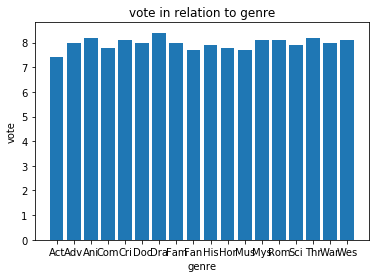

In [159]:
#So why do so many companies(20%) doing drama? Is it because they can get higher voting or drama has low cost but high return?
#get vote in relationship to the genre of all
x4=list(df_complex_company['most_common_genre'].apply(convert_dit))
y4=list(df_complex_company['mean_vote'])
plt.bar(x4, y4)
plt.title('vote in relation to genre')
plt.xlabel('genre')
plt.ylabel('vote')
plt.show()

#Therefore, in general the drama has the highest rating among all the genres though it only has 0.4 Billion profit. To win the critics view and possbile high reputations
#companies would like to do such genre




**The graph above shows that in general drama has the highest rating among all the genres although it only has 0.4 Billion profit. To win the critics view and possbile high reputations companies would like to do such genre.**

**For now, we have the top 500 most profitable company. We might woder if there is some relationship between those companies like they might cooperate to make a movie.**

In [160]:
# Now we need to find out why actions movies are the hottest genre among the most successful 500 
# production companies. 

# To unvail the magic behind action movies, firstly let's get a list action movies made by the 
# top 500 companies.
top_500 = df_complex_company[0:500]
top_500_action = top_500[top_500['most_common_genre']=="Action"]
top_500_action = top_500_action.reset_index(drop=True)
print('The shape of top_500_action is',top_500_action.shape)
top_500_action.head()

The shape of top_500_action is (64, 4)


,Company,mean_net_profit,mean_vote,most_common_genre
0,"Colorado Office of Film, Television & Media",1.316249e+09,7.30,Action
1,Québec Production Services Tax Credit,1.316249e+09,7.30,Action
2,Abu Dhabi Film Commission,1.316249e+09,7.30,Action
3,Lightstorm Entertainment,9.799764e+08,7.26,Action
4,Ian Bryce Productions,8.814051e+08,5.80,Action


In [161]:
top_action_company_list = top_500_action['Company']
# Then we loop over our data frame and create an index list of row number of the movies 
# made by the top action companies
top_action_movie_list = []
for i in range(len(df)):
  genre = df.loc[i]['genres'].split('|')
  companies = df.loc[i]['production_companies'].split('|')
  for j in top_action_company_list: 
    if j in companies and 'Action' in genre: 
      top_action_movie_list.append(i)
# create another list figuring out how many top companies working on the same movie together
coorp_list = []
unique_action_movie = list(set(top_action_movie_list))
for i in unique_action_movie: 
  size = top_action_movie_list.count(i)
  coorp_list.append(size)
Action_top_company_movies = df.iloc[unique_action_movie]
#Action_top_company_movies = Action_top_company_movies.reset_index(drop=True)
print('The shape of Action_top_company_movies is:',Action_top_company_movies.shape)
Action_top_company_movies.head()


The shape of Action_top_company_movies is: (260, 14)


,budget,genres,keywords,original_title,popularity,production_companies,production_countries,release_date,revenue,spoken_languages,title,vote_average,vote_count,net_profit
0,237000000,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,Avatar,150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009-12-10,2787965087,English|Español,Avatar,7.2,11800,2550965087
1,300000000,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Pirates of the Caribbean: At World's End,139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America,2007-05-19,961000000,English,Pirates of the Caribbean: At World's End,6.9,4500,661000000
3,250000000,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,The Dark Knight Rises,112.312950,Legendary Pictures|Warner Bros.|DC Entertainme...,United States of America,2012-07-16,1084939099,English,The Dark Knight Rises,7.6,9106,834939099
515,69000000,Action|Fantasy|Horror,usa president|vampire|steam locomotive|america...,Abraham Lincoln: Vampire Hunter,38.634767,Twentieth Century Fox Film Corporation|Bazelev...,United States of America,2012-06-20,112265139,English,Abraham Lincoln: Vampire Hunter,5.5,1269,43265139
5,258000000,Fantasy|Action|Adventure,dual identity|amnesia|sandstorm|love of one's ...,Spider-Man 3,115.699814,Columbia Pictures|Laura Ziskin Productions|Mar...,United States of America,2007-05-01,890871626,English|Français,Spider-Man 3,5.9,3576,632871626


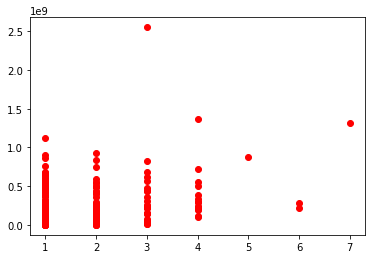

In [162]:
# First of all, lets see if number of big action companies working together would increase 
# a movie's profit
coorp_list_profit = list(Action_top_company_movies['net_profit'])

plt.plot(coorp_list, coorp_list_profit, 'ro')
plt.show()

**This graph shows there is no significant relationship between numbers of companies cooperating together and the revenue they have. As shown in the graph the highest revenue earned is when 3 big companies cooperate rather than 8. **

**Conclusion: At the end of this section, we have found that experienced companies, that are good at making certain genres, do not have a major influence on increasing the profit of that movie. In other words, a company that has produced multiple Horror movies is not guaranteed to make a profitable Horror movie. Secondly, we have found that genre such as "Animation" and words such as 'War and power" do impact a movie's profit as we can see from the graphs above. We have also found that among the best profitable companies, the average vote for the movies they make is within the range of 6.7 to 7.2. Thus we can assume that movies with average votes around 7 will have a better chance of gaining more profit. Lastly, we tested our hypothesis to see if a coorperation that was among the top 500 most profitable companies influenced future profit margins, but the result was negative. One reason to explain our hypothesis to be wrong could be, focusing on production companies as the major factors in the influence of a movie's revenue is too narrow. In fact, a movie's revenue may highly rely on its choice of genres and contents.**

# **Looking at Genre and Profit Margins**

In [163]:
#df_credits = pd.read_csv("tmdb_5000_credits.csv")
df_movies =  pd.read_csv('tmdb_5000_movies.csv')
df_movies["genres"] = df_movies["genres"].apply(json.loads)

In [164]:
df_movies.rename( columns = {'vote_average':'voting'}, inplace = True)

**Data cleaning**

In this part we use the same tmdb_5000_movies.csv but this time we keep the row which has profit>0 

In [165]:
# discard rows where voting revenue or budget is smaller than 0 
# it doesn't make sense for those data to be smaller than zero
df_movies.dropna(axis=0, how='any', subset=["voting","revenue"], inplace=True)
df_movies = df_movies[df_movies.revenue > 0]
df_movies = df_movies[df_movies.voting > 0]
df_movies = df_movies[df_movies.budget >0]
df_movies["profit"] = np.round(df_movies["revenue"] - df_movies["budget"])


In [166]:
#extracting all the generes 
all_genres = []
for items in df_movies["genres"]:
    for names in items:
        all_genres.append(names["name"])
all_genres = list(set(all_genres))

In [167]:

#creating new columns for all genres
for genre in all_genres:
    canvas = np.zeros(len(df_movies["genres"]))
    for i in np.arange(len(df_movies["genres"])):
        for names in df_movies["genres"].iloc[i]:
            if(names["name"]==genre):
                canvas[i] = 1
                break;
    df_movies[genre] = canvas

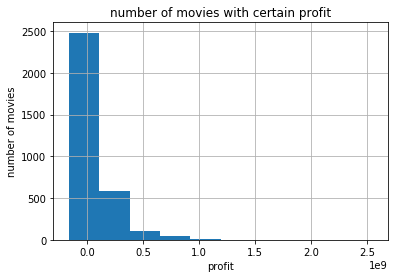

In [168]:
df_profit = df_movies["profit"]
df_profit.hist()
plt.title("number of movies with certain profit")
plt.xlabel("profit")
plt.ylabel("number of movies")
plt.show()

**As we can see from the above graph, the distribution of profit skew right. Thus,to make it approximate normally distributed, we take its log.**

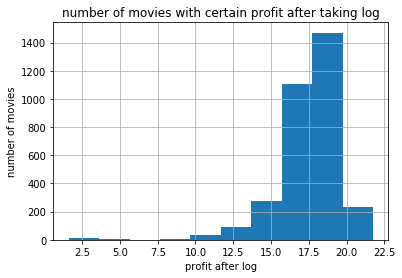

In [169]:
# As we can see, the distribution of profit skew right.
# Thus, to make it approximate normally distributed, we take its log
df_movies['log_profit'] = np.log(df_movies.revenue)
std = np.std(df_movies["log_profit"])
mean = np.mean(df_movies["log_profit"])
df_movies = df_movies[(df_movies.log_profit > mean-2*std) | (df_movies.log_profit < mean+2*std)]

df_log_profit = df_movies["log_profit"]

df_log_profit.hist()
plt.title("number of movies with certain profit after taking log")
plt.xlabel("profit after log")
plt.ylabel("number of movies")
plt.show()

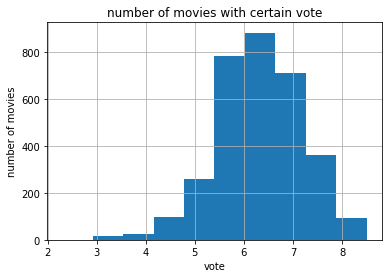

In [170]:
df_movies["voting"].hist()
plt.title("number of movies with certain vote")
plt.xlabel("vote")
plt.ylabel("number of movies")
plt.show()

**From above graph we can see that voting has approximate noraml distribution.**

In [171]:
# Based on the result from below code, we can see that there is no strong 
# correlation between voting and log profit 
df_movies['voting'].corr(df_movies['log_profit'])

0.1309674285007543

**We can also verify this result by directly looking at the graph.**

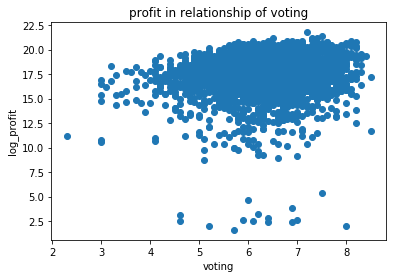

In [172]:

x = df_movies['voting'].values
y = df_movies['log_profit'].values
plt.scatter(x, y)
plt.title('profit in relationship of voting')
plt.xlabel('voting')
plt.ylabel('log_profit')
plt.show()

From the graph above, there is huge clustering in the middle of the plot. Thus the correlation between vote and log_profit is weak.

**Now, we attempt to discover potential relationship between genres and profit. We firstly decided the length of our combinations by ploting the distribution of the number of genres.**

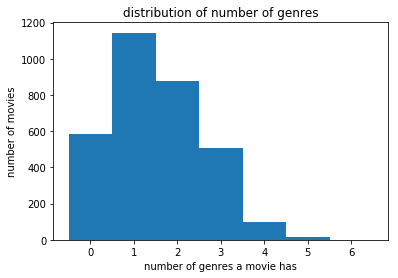

In [173]:
start_index = list(df_movies.columns).index("Horror")
end_index = list(df_movies.columns).index("log_profit")
num_of_genres = np.zeros(len(df_movies))
for i in np.arange(start_index, end_index):
  num_of_genres = num_of_genres + df_movies.iloc[:,i]
plt.hist(num_of_genres, align="left", bins=np.arange(0,8))
plt.title("distribution of number of genres")
plt.xlabel("number of genres a movie has")
plt.ylabel("number of movies")
plt.show()

From the graph above, we can conclude that most of the movies have only single or at most 2 genres combined. 

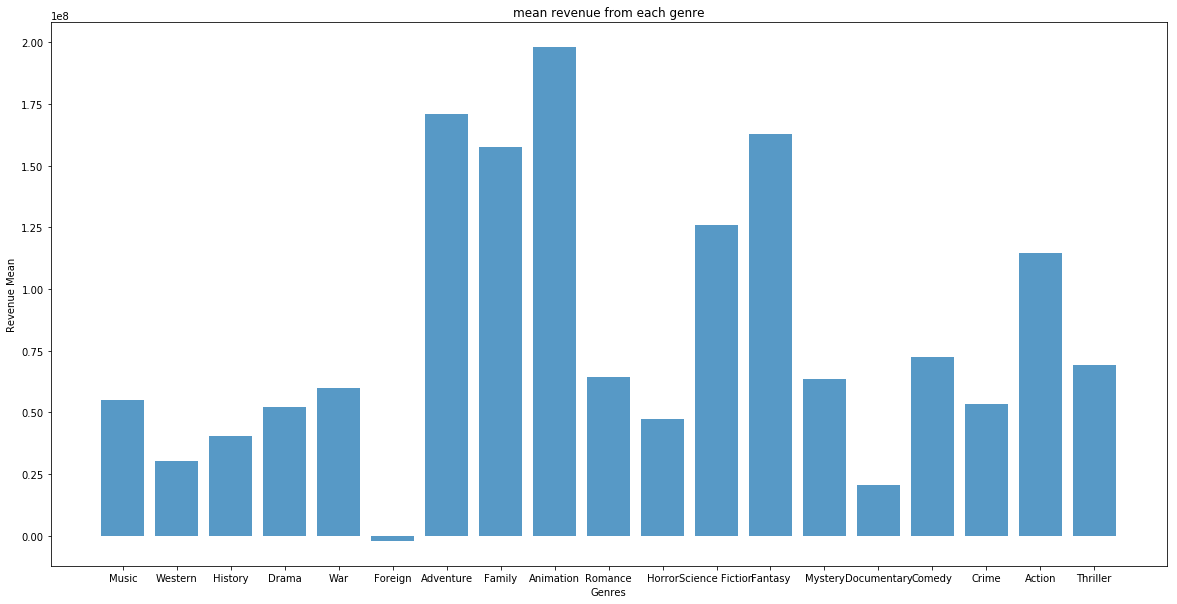

In [174]:
revenue_by_genre = []
for genre in all_genres:
    revenue_by_genre.append(df_movies.loc[df_movies[genre]==1]["profit"].mean(axis=0))
y_pos = np.arange(len(all_genres))
plt.figure(figsize=(20,10))
plt.bar(y_pos, revenue_by_genre,align = 'center',alpha =0.75)
plt.xticks(y_pos, all_genres)
plt.title('mean revenue from each genre')
plt.xlabel('Genres')
plt.ylabel('Revenue Mean')
plt.show()

**As we can see from above graph; Animation, Adventure and Fantasy are the top three most profitable genres. However, it's also very possible that they are profitable because these three genres often appear in the same movie. Now, we try to find out the most profitable combination of genres.**

**Now we will check to see what combinations of genre yield the highest profit margins.**

In [175]:
# this function is used to return the desired genre combination 
# all_genres is a list of string which we used to genreate combination from 
# input_genres is a list we want to search 
# this fucntion returns all combinations contain input_genres
def desired_combination(all_genres, input_genres, r):
  # r is used to define the length of our combination
  canvas = list(itertools.combinations(all_genres,r))
  desired_combinations=[]
  for combination in canvas: 
    flag = True
    for genre in input_genres:
      #~ is wrong
      if not (genre in combination):
        flag = False
    if(flag):
      desired_combinations.append(combination)
  return desired_combinations

In [176]:
# this function is used to return a list contains top r most-profitable combinations
# input_list is the combination we search through
# r is used to defined how many we want most-profitable combinations we want
def optimal_combination(input_list, r):
  combination_values = []
  for combination in input_list:
    df = df_movies
    for genre in combination:
      df = df.loc[df[genre]==1]
    combination_values.append(np.mean(df["profit"]))
  combination_values = pd.Series(combination_values).fillna(-1).tolist()
  max_index = (np.argsort(combination_values))[len(combination_values)-r : len(combination_values) ]
  return np.array(input_list)[max_index], np.array(combination_values)[max_index]

In [177]:
# this method returns r most-profitable examples with genres in input_genres
def example_movies(input_genres,r):
  df = df_movies
  for genre in input_genres:
    df = df.loc[df[genre]==1]
  df.sort_values(by=["profit"],ascending =False, inplace = True)
  index = np.arange(r)
  if len(df["title"]) < r:
    index = np.arange(len(df["title"]))
  return np.array(df["title"])[index]

In [178]:
#@title Default title text
best_combination = {}
for genre in all_genres:
  all_comb = desired_combination(all_genres, [genre], 3)
  best_comb = optimal_combination(all_comb, 1)
  best_combination[genre] = [ ', '.join(best_comb[0][0]), ''.join(str(e) for e in best_comb[1]), ', '.join(example_movies(best_comb[0][0], 3))]
df_genre = pd.DataFrame.from_dict(best_combination, orient='index')
df_genre.columns = ['best_combination', 'mean_profit', 'example_movies']
df_genre

,best_combination,mean_profit,example_movies
Music,"Music, Action, Thriller",386006740.0,The Bodyguard
Western,"Western, Drama, Adventure",153964689.857,"Dances with Wolves, The Revenant, True Grit"
History,"Western, History, Crime",96308889.0,Butch Cassidy and the Sundance Kid
Drama,"Drama, Family, Animation",255137657.556,"The Lion King, Inside Out, Pocahontas"
War,"War, Horror, Action",145529201.0,Dracula Untold
Foreign,"Foreign, Romance, Comedy",0.0,Bran Nue Dae
Adventure,"Adventure, Fantasy, Crime",570000000.0,Suicide Squad
Family,"Family, Fantasy, Mystery",440251502.0,"Harry Potter and the Order of the Phoenix, The..."
Animation,"Animation, Fantasy, Comedy",280734082.607,"Shrek 2, Shrek the Third, Shrek Forever After"
Romance,"Romance, Fantasy, Crime",328583407.0,The Mask


**Conclusion:
From the chart above, we can search the most profitable combination of all genres. There are couple rearks worth further exploring. Since the average of foreign is losing money. It's reasonable to have the "most_profit" as zero. In addtion, we can also find out that there are strong assosiation between genres and profit. The most profitable comibination is often the most profitable combination of the other two genres in this comibination. For example, Animation ties with comedy. Fantsy, Adventure, Crime also have strong ties with each other. This trend is possibly caused by the fact that most adventure content is related to fantasy. Some of the famous examples include Harry Porter and Maze Runner. Animation recevied the highest profit might casued by the widely used of 3D technology during production. The beauty of the graphic attracts all ages which expanded the source of revenue. The variety of audience also expanded the revenue of Animation. Unlike war crime or horror, animations are sutiable for all ages and all groups of viewers. They can be families or adults. This trait also increase the profit of Animation.**

# ***Part 3: Checking if Actors have an influence on ratings and profit***

**Introduction: In the next part we will test to see the influence of actors and the overall movie ratings. It is our goal to show that actors have 
an influence on the overall movie ratings. By doing this we will look at every movies actors and assign them an average rating, as long as they
have appeared in more then 5 movies. We will then take this rating and compare to the movie rating. If there is a substantial difference, we will 
then take actors that scored higher and see if their score can influence the actors overall score. If their score makes a huge difference then we 
can conclude that if the movie had enough budget to support the higher rated actor, then their movie would have scored better. Thus, this prediction
would lead to the movie having higher revenue.**

**Data gathering and cleaning**

Here we will read both dataframes to get information on things related movies as well as all the casts information.

In [179]:
# print all variables, not just last one
#InteractiveShell.ast_node_interactivity = "all"
# read movie stats and cast into dataframes
df_tmdb_cast = pd.read_csv('tmdb_5000_credits.csv')
df_tmdb_movie = pd.read_csv('tmdb_5000_movies.csv')

df_tmdb_cast['cast'] = df_tmdb_cast['cast'].apply(json.loads)
df_tmdb_cast['crew'] = df_tmdb_cast['crew'].apply(json.loads)
df_tmdb_movie['genres'] = df_tmdb_movie['genres'].apply(json.loads)
df_tmdb_movie['keywords'] = df_tmdb_movie['keywords'].apply(json.loads)
df_tmdb_movie['production_companies'] = df_tmdb_movie['production_companies'].apply(json.loads)
df_tmdb_movie['production_countries'] = df_tmdb_movie['production_countries'].apply(json.loads)
df_tmdb_movie['spoken_languages'] = df_tmdb_movie['spoken_languages'].apply(json.loads)


**Here we will start cleaning unnecessary columns from the original dataset and add in a profit column.**

In [180]:
# function that calculates the gross income of a film
def profit(budget,revenue):
    profit = (revenue-budget)
    return profit

# calculate profit for each film and add it to the movie dataset as a new column
profit_list = profit(df_tmdb_movie['budget'],df_tmdb_movie['revenue'])
df_tmdb_movie['profit']=profit_list

# movie stats cleaning: drop unnecessary fields and invalid rows
df_tmdb_movie.drop(['homepage','keywords','original_language','original_title','overview','popularity','production_companies','production_countries','release_date','runtime','spoken_languages','status','tagline','vote_count'], axis=1, inplace=True)
df_tmdb_movie = df_tmdb_movie[df_tmdb_movie.revenue != 0]
df_tmdb_movie = df_tmdb_movie[df_tmdb_movie.budget != 0]


**Here we Merge the two dataframes into one.**

In [181]:
# cast data cleaning
df_tmdb_cast.drop(['crew', 'movie_id'], axis = 1, inplace = True)

# merge movie stats and cast on titles to create a comprehensive dataset
movie_info = pd.merge(df_tmdb_cast, df_tmdb_movie, on='title')
movie_info.set_index(['title'], inplace = True)


**Here we apply a method to genre to make it easy to manipulate.**

In [182]:
# new standardize_genre: easy to read and works like a charm
def standardize_genre(keywords): 
  str = ' '.join([x['name'] for x in keywords])
  return str.split()

movie_info['genres'] = movie_info['genres'].apply(standardize_genre)

movie_info.head()

,cast,budget,genres,id,revenue,vote_average,profit
title,,,,,,,
Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...",237000000,"[Action, Adventure, Fantasy, Science, Fiction]",19995,2787965087,7.2,2550965087
Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...",300000000,"[Adventure, Fantasy, Action]",285,961000000,6.9,661000000
Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...",245000000,"[Action, Adventure, Crime]",206647,880674609,6.3,635674609
The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...",250000000,"[Action, Crime, Drama, Thriller]",49026,1084939099,7.6,834939099
John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...",260000000,"[Action, Adventure, Science, Fiction]",49529,284139100,6.1,24139100


**Here we will create a new dataframe to hold actor traits and to drop duplicate occurances.**

In [183]:
# group cast info by actors. each field of an actor starts with a newline

# extract all actor names of each film
actor_names_for_every_film = []
actor_list = set()

# loop through all films in dataset
for film_name in movie_info.index: 
    current_film_actors_info = movie_info['cast'].loc[film_name]
    current_film_actor_names = []
    
    # loop through all single actors in a film
    for current_actor in current_film_actors_info:
        try:
            name = current_actor['name']
        except:
            continue
        current_film_actor_names.append(name)
        actor_list.add(name)
    actor_names_for_every_film.append(current_film_actor_names)
    
# add this new list to datafarme as a new field
movie_info['actors'] = actor_names_for_every_film

# drop cast column and reorder columns
movie_info = movie_info[['id', 'genres', 'budget', 'revenue', 'profit', 'actors','vote_average']]

# value checking
# originally with duplication, the len was 84006 and Depp appeared several times
movie_info.head()
movie_info['actors']['Avatar'].head()
len(actor_list)

45133

**Here we will create a new column in our data frame for actors and their work.**

In [184]:
# creat a new dataframe for actors
actors = pd.DataFrame()
actors['name'] = list(actor_list)
actors.set_index(['name'], inplace = True)

# value checking
actors.head()
len(actors)
actors[actors.index == 'Johnny Depp']

# initialize a new column in actor df to keep the actor's work
actors["work(id)"] = [[] for i in range(len(actors.index))]

# figure out each actor appears in which films
# loop through all films
for film in movie_info.index:
  idd = movie_info['id'].loc[film]
  actor_list =  movie_info['actors'].loc[film]
  try: 
    rate = int(movie_info['avg_vote'].loc[film])
  except: 
    rate = 0
    
  # add the film's id to all its actors' work colum and update film count
  for actor in actor_list:
    actors["work(id)"].loc[actor].append(idd)

**Here we will add up the amount of movies that each actor appeared in and eliminate
actors that only appeared in less then 5 movies.**

In [185]:
# count movies shot
movies_shot_number = []
for actor in actors.index: 
  number = len(actors.loc[actor][0])
  movies_shot_number.append(number)
actors["movies#"] = movies_shot_number

# sort actors regarding how many films they acted and keep the top 10%
actors.sort_values(by = ['movies#'], ascending = False, inplace = True)
actors.head()

,work(id),movies#
name,,
Samuel L. Jackson,"[99861, 24428, 258489, 1726, 10138, 100402, 10...",53
Robert De Niro,"[39451, 9992, 17711, 10555, 2270, 49021, 11371...",48
Matt Damon,"[157336, 65759, 2503, 324668, 68724, 163, 2862...",45
Morgan Freeman,"[49026, 155, 2698, 272, 74, 75612, 157353, 271...",45
Bruce Willis,"[95, 72559, 9471, 163, 1571, 76163, 18, 47964,...",44


**Below we will find the average vote for each actor for every movie they starred in that is mention in the dataframe.**

In [186]:
for i in range(6): 
  actors = actors[actors['movies#'] != i ] 
# Vote average
rate_list = [0 for i in range(len(actors))]
actor_index = 0 
while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for i in movie_list: 
    rate = movie_info.loc[movie_info['id']== i]['vote_average'][0]
    rate_list[actor_index] += rate
  rate_list[actor_index] = rate_list[actor_index]/actors['movies#'][actor_index]
  actor_index += 1
actors['avg_vote'] = rate_list

# value checking
actors.head()

,work(id),movies#,avg_vote
name,,,
Samuel L. Jackson,"[99861, 24428, 258489, 1726, 10138, 100402, 10...",53,6.626415
Robert De Niro,"[39451, 9992, 17711, 10555, 2270, 49021, 11371...",48,6.454167
Matt Damon,"[157336, 65759, 2503, 324668, 68724, 163, 2862...",45,6.673333
Morgan Freeman,"[49026, 155, 2698, 272, 74, 75612, 157353, 271...",45,6.591111
Bruce Willis,"[95, 72559, 9471, 163, 1571, 76163, 18, 47964,...",44,6.302273


**Now we check to see what is the average profit each actor contributed to its movie. We base this on the average profit of each movie they starred in.**

In [187]:
#find average profit of movies they shot
profit_list = [0 for i in range(len(actors))]
actor_index = 0 
while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for movie_id in movie_list: 
    profit = movie_info.loc[movie_info['id']== movie_id]['profit'][0]
    profit_list[actor_index] += profit
  profit_list[actor_index] = profit_list[actor_index]/actors['movies#'][actor_index]
  actor_index += 1
  
actors['avg_profit'] = profit_list

# value checking
actors.head()

,work(id),movies#,avg_vote,avg_profit
name,,,,
Samuel L. Jackson,"[99861, 24428, 258489, 1726, 10138, 100402, 10...",53,6.626415,2.050035e+08
Robert De Niro,"[39451, 9992, 17711, 10555, 2270, 49021, 11371...",48,6.454167,6.223366e+07
Matt Damon,"[157336, 65759, 2503, 324668, 68724, 163, 2862...",45,6.673333,1.094253e+08
Morgan Freeman,"[49026, 155, 2698, 272, 74, 75612, 157353, 271...",45,6.591111,1.399995e+08
Bruce Willis,"[95, 72559, 9471, 163, 1571, 76163, 18, 47964,...",44,6.302273,1.070034e+08


**Below we are getting the preferred movie genre that the actor scored the best in.**

In [188]:
# get each actor's type
genre_list = [0 for i in range(len(actors))]

actor_index = 0
while actor_index < len(actors):
  genre_list[actor_index] = {}
  actor_index = actor_index + 1

actor_index = 0
while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for movie_id in movie_list:
    genres = movie_info.loc[movie_info['id']== movie_id]['genres'][0]
    for genre in genres:
      if genre not in genre_list[actor_index]:
        genre_list[actor_index][genre] = 0
      genre_list[actor_index][genre] = genre_list[actor_index][genre] + 1
  genre_list[actor_index] = sorted(genre_list[actor_index], key=genre_list[actor_index].__getitem__, reverse=True)[0]
  actor_index += 1
  
actors['main_type'] = genre_list

# value checking
actors.head()

,work(id),movies#,avg_vote,avg_profit,main_type
name,,,,,
Samuel L. Jackson,"[99861, 24428, 258489, 1726, 10138, 100402, 10...",53,6.626415,2.050035e+08,Action
Robert De Niro,"[39451, 9992, 17711, 10555, 2270, 49021, 11371...",48,6.454167,6.223366e+07,Drama
Matt Damon,"[157336, 65759, 2503, 324668, 68724, 163, 2862...",45,6.673333,1.094253e+08,Drama
Morgan Freeman,"[49026, 155, 2698, 272, 74, 75612, 157353, 271...",45,6.591111,1.399995e+08,Drama
Bruce Willis,"[95, 72559, 9471, 163, 1571, 76163, 18, 47964,...",44,6.302273,1.070034e+08,Thriller


**Now we will collect the average profits of each film that are for each actors main genre.**

In [189]:
# calculate the avg profit the the films that suit each actor's type
profit_list = [0 for i in range(len(actors))]
actor_index = 0
film_counter = 0

while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for movie_id in movie_list:
    if actors['main_type'][actor_index] not in movie_info[movie_info['id'] == movie_id].genres[0]:
      continue
    film_counter += 1
    profit = movie_info.loc[movie_info['id']== movie_id]['profit'][0]
    profit_list[actor_index] += profit
  profit_list[actor_index] = profit_list[actor_index]/film_counter
  actor_index += 1
  film_counter = 0
  
actors['avg_profit(suitable)'] = profit_list

# value checking
actors.head()

,work(id),movies#,avg_vote,avg_profit,main_type,avg_profit(suitable)
name,,,,,,
Samuel L. Jackson,"[99861, 24428, 258489, 1726, 10138, 100402, 10...",53,6.626415,2.050035e+08,Action,2.587051e+08
Robert De Niro,"[39451, 9992, 17711, 10555, 2270, 49021, 11371...",48,6.454167,6.223366e+07,Drama,3.949146e+07
Matt Damon,"[157336, 65759, 2503, 324668, 68724, 163, 2862...",45,6.673333,1.094253e+08,Drama,1.208390e+08
Morgan Freeman,"[49026, 155, 2698, 272, 74, 75612, 157353, 271...",45,6.591111,1.399995e+08,Drama,1.332335e+08
Bruce Willis,"[95, 72559, 9471, 163, 1571, 76163, 18, 47964,...",44,6.302273,1.070034e+08,Thriller,1.469351e+08


In [190]:
def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))
main_actors = [ ]
actors_index = list(actors.index)
movie_list = movie_info.index
for i in range(len(movie_info)): 
  actor_list = movie_info.loc[movie_list[i]]['actors']
  try: 
    new_actor = intersect(actors_index,actor_list)
  except: 
    new_actor = np.nan
  main_actors.append(new_actor)

movie_info['main_actors'] = main_actors
movie_info.dropna(axis=0,how = 'any', inplace = True)

movie_info = movie_info[movie_info['vote_average'] !=0]

**Below we are checking for the mean actors score. We base this on the average rating of all the movies that they starred in.**

In [191]:
# Now we calcuate the mean actor scores for each movie
actor_vote = []
movie_list = movie_info.index
for i in range(len(movie_info)): 
  actor_list = movie_info.loc[movie_list[i]]['main_actors']
  actor_rate = 0 
  for j in actor_list: 
    actor_rate = actor_rate + actors.loc[j]['avg_vote']
  try: 
     actor_rate = actor_rate/len(actor_list)
  except: 
     actor_rate = np.nan
  actor_vote.append(actor_rate)
  

**Now we are checking for similiarties and if there are any coorelations to the data.**

The similarity between actor_vote and vote average is
0.903821199338


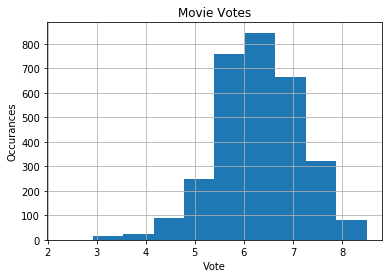

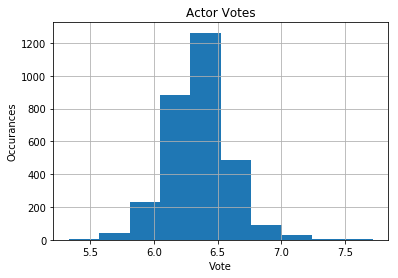

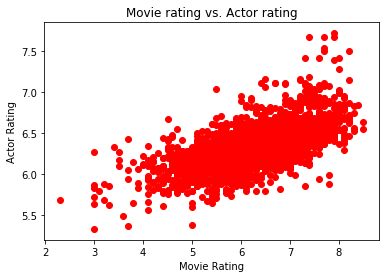

In [192]:
movie_info['actor_vote'] = actor_vote
movie_info.dropna(axis=0,how='any',inplace = True)

# now we calculate the similarity between actor_mean_votes and the real movie average_votes
actor_mean_votes = movie_info['actor_vote']
average_votes = movie_info['vote_average']
subtract = [ abs(actor_mean_votes[i]-average_votes[i]) for i in range(len(actor_mean_votes ))]

similarity = 1- sum([subtract[i]/average_votes[i] for i in range(len(actor_mean_votes ))])/len(subtract)

print('The similarity between actor_vote and vote average is')
print (similarity)

#Plot Graphs
movie_info.vote_average.hist()
plt.title('Movie Votes')
plt.xlabel('Vote')
plt.ylabel('Occurances')
plt.show()

movie_info.actor_vote.hist()
plt.title('Actor Votes')
plt.xlabel('Vote')
plt.ylabel('Occurances')
plt.show()

xplot = movie_info.vote_average.values
yplot = movie_info.actor_vote.values
plt.scatter(xplot,yplot, color='red')
plt.title('Movie rating vs. Actor rating')
plt.xlabel('Movie Rating')
plt.ylabel('Actor Rating')
plt.show()

**From the above graphs we can see that there is a similiar average rating for over all movie and actor. This shows evidence that actors do influence the score, however there are other factors that can influence this score. This could be budget, effects, and the writing script.**

**Conclusion: With all the data we collected and the areas we determined were important, we can conclude that actors do have some influeunce on movie profits. Our hypothesis is that if there were no budget contraints or other external factors, that replacing a lower rated actor with a higher rated actor would yield a higher score for that movie. This would only pertain if the actors shared the same preferred genre. Another factor that could influence this data would to see how much each actor was payed for each movie as well as where the other expenses were used. This would require much more data then we have present or can obtain, so we have to resort to speculation. Another factor is the ratings for movies. Most people seem to give movies an average rating rather then pick one of the two extremes.**


## Limitation Discussion##


There are still a lot of questions to answer regarding what could determine a great movie and our exploration is far from complete. First, the dataset only contains 5000 movies in total, and after excluding those with missing data(like missing budget and revenue), the data became even smaller. There might not be enough movies from each genre to present in the database for analysis and the dataset doesn't have the most current movies, making it not able to represent the situation up-to-day.  We can't be very sure that this dataset could epitomize the situations in the whole movie industry.The dataset lacks some information that prevents us to further analyze the relationship between certain factors and the success of the movies like the total spending on actors, or special effects.etc. From there, we could make a more specific analysis. The dataset has much information we could explore but it is far from enough to find the success formula of the movie.

## Final Conclusion##

   Our analysis shows that numerous factors could have influenced the indicator of success: revenue, profit, or the votes. The more budget spends on a movie the higher the revenue. Movies with specific keywords like "space war" would earn much more than movies with other keywords but in terms of rating, "wrongful imprisonment" and "crime family" are the best. 
    
   The genre have a strong relationship with the revenue as well.There is a preference in the top 500 companies that earn the most revenue to do adventure movies, but the highest rating movies come from the drama genre. Certain combinations of the genre could result in higher revenue in general: Animation movies combined with fantasy or comedy makes the most of all animation movies. 
    
   Choosing of actors do have some influence over revenue and profits, but more likely affects the votes score.
    
   On the other hand, things we thought to have a strong influence in the success of the movies like the cooperation of big companies doesn't prove to have many relationships to the success of the movies: the one with 8 top 500 earning companies in the dataset only generate a mediocre revenue among all movies. Our 2 indicators for successful movies: revenue and votes don't have strong relationships with each other. In general, it is not the case that higher ratings brought to higher revenue, most movies around scores of 6.8-7.0 has the highest revenue.
    
   In all, many factors could influence the success of the movies to different degrees. Certainly more explorations need to be done on larger datasets to find out what are the most important factors on the success of the movies no matter they are explicit or implicit and the success formula for the movie might be built to change the industry.